In [2]:
#
import os
import glob
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torchvision 
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Library Sklearn & Timm
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cek device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [3]:

SUMBER_DATASET_PATH = "C:/Document/TAAAAA CUYYYY/X-SDD/datas" 
# Path output untuk data yang sudah di-split
OUTPUT_SPLIT_PATH = "C:/Document/TAAAAA CUYYYY/X-SDD/TA_Klasifikasi_Cacat/dataset_split"

# --- KONFIGURASI MODEL ---
NUM_CLASSES = 7         # 7 kelas cacat
BATCH_SIZE = 32         # Sesuai proposal
NUM_EPOCHS = 100        # Sesuai proposal
LEARNING_RATE = 1e-4    # Sesuai proposal
IMG_SIZE = 224

# Statistik normalisasi ImageNet
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

# Nama model yang akan diuji
MODEL_NAMES = ['mobilenet', 'mobilevit', 'swin']

In [11]:


# Pastikan variabel ini SAMA PERSIS dengan yang ada di Sel 2
DEBUG_PATH = "C:/Document/TAAAAA CUYYYY/X-SDD/datas" 

# 1. Kita cari tahu dulu ada folder apa saja di dalam path itu
folders_ditemukan = glob.glob(os.path.join(DEBUG_PATH, "*"))

print(f"Path yang dicek: {DEBUG_PATH}")
print("="*30)
print(f"Folder/file yang ditemukan di dalamnya ({len(folders_ditemukan)}):")
for f in folders_ditemukan:
    print(f"  -> {f}")

# 2. Kita tes pola pencarian gambar kita
pola_pencarian_gambar = os.path.join(DEBUG_PATH, "*", "*.png")
gambar_ditemukan = glob.glob(pola_pencarian_gambar)

print("="*30)
print(f"Mencoba mencari gambar dengan pola: {pola_pencarian_gambar}")
print(f"Total gambar ditemukan: {len(gambar_ditemukan)}")
if len(gambar_ditemukan) > 0:
    print(f"Contoh gambar pertama: {gambar_ditemukan[0]}")

Path yang dicek: C:/Document/TAAAAA CUYYYY/X-SDD/datas
Folder/file yang ditemukan di dalamnya (7):
  -> C:/Document/TAAAAA CUYYYY/X-SDD/datas\finishing roll printing
  -> C:/Document/TAAAAA CUYYYY/X-SDD/datas\iron sheet ash
  -> C:/Document/TAAAAA CUYYYY/X-SDD/datas\oxide scale of plate system
  -> C:/Document/TAAAAA CUYYYY/X-SDD/datas\oxide scale of temperature system
  -> C:/Document/TAAAAA CUYYYY/X-SDD/datas\red iron
  -> C:/Document/TAAAAA CUYYYY/X-SDD/datas\slag inclusion
  -> C:/Document/TAAAAA CUYYYY/X-SDD/datas\surface scratch
Mencoba mencari gambar dengan pola: C:/Document/TAAAAA CUYYYY/X-SDD/datas\*\*.png
Total gambar ditemukan: 142
Contoh gambar pertama: C:/Document/TAAAAA CUYYYY/X-SDD/datas\finishing roll printing\6001.png


In [4]:
#
def split_dataset(sumber_path, output_path):
    print(f"Membaca data dari: {sumber_path}")
    
    # Kumpulkan semua path gambar (asumsi format .png, ganti jika perlu)
    print("Mencari file .png, .jpg, dan .jpeg...")

    exts = ["*.png", "*.jpg", "*.jpeg"]
    image_paths = []
    for ext in exts:
        pattern = os.path.join(sumber_path, "*", ext)
        image_paths.extend(glob.glob(pattern))

    print(f"Total ditemukan {len(image_paths)} gambar (png/jpg/jpeg)") 
    
    if not image_paths:
        print(f"Error: Tidak ada gambar .png ditemukan di {sumber_path}. Periksa path/format file.")
        return

    # Ambil label (nama folder)
    labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
    print(f"Total gambar ditemukan: {len(image_paths)}")

    # Stratified Split 90% train, 10% test
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
    train_indices, test_indices = next(sss.split(image_paths, labels))
    print(f"Membagi data: {len(train_indices)} latih (90%), {len(test_indices)} uji (10%).")

    
    def copy_files(indices, set_name):
        for idx in indices:
            src_path = image_paths[idx]
            label = labels[idx]
            dest_dir = os.path.join(output_path, set_name, label)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(src_path, dest_dir)

    if os.path.exists(output_path):
        print(f"Folder {output_path} sudah ada. Menghapus folder lama...")
        shutil.rmtree(output_path)
    
    # Salin file
    copy_files(train_indices, "train")
    copy_files(test_indices, "test")
    print(f"Pemisahan data selesai. Data disimpan di: {output_path}")

# --- PENTING! JALANKAN INI HANYA SEKALI ---
print("Memulai pemisahan dataset...")
# split_dataset(SUMBER_DATASET_PATH, OUTPUT_SPLIT_PATH)

Memulai pemisahan dataset...


In [4]:
#
# Definisikan transformasi
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # Augmentasi 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15), 
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_NET_MEAN, IMAGE_NET_STD) # 
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_NET_MEAN, IMAGE_NET_STD) # 
    ]),
}
print("Transformasi data berhasil didefinisikan.")

Transformasi data berhasil didefinisikan.


In [5]:
#
def create_dataloaders(data_dir, batch_size=32):
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")

    # Dataset 'train' (90%) akan kita pecah lagi
    full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
    
    # Dataset 'test' (10%) pakai transform 'test'
    test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])
    
    # Sesuai proposal: 90% data latih dipecah 80% (latih) dan 20% (validasi) [cite: 385]
    total_train_size = len(full_train_dataset)
    val_size = int(total_train_size * 0.20)
    train_size = total_train_size - val_size
    
    print(f"Total data 90%: {total_train_size} -> Dibagi jadi {train_size} latih & {val_size} validasi.")
    
    # Pecah datanya
    train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(42))
    
    # --- PENTING ---
    # Saat validasi, kita ingin pakai transform 'test' (tanpa augmentasi)
    # Jadi kita 'tweak' dataset validasi-nya
    val_subset.dataset = datasets.ImageFolder(train_dir, transform=data_transforms['test'])
    # Ini trik agar 'val_subset' tetap menunjuk ke indeks yang benar, tapi transform-nya beda

    # Buat DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    class_names = full_train_dataset.classes
    print(f"Kelas terdeteksi: {class_names}")

    return train_loader, val_loader, test_loader, class_names

# --- Eksekusi fungsi untuk memuat data ---
train_loader, val_loader, test_loader, class_names = create_dataloaders(OUTPUT_SPLIT_PATH, BATCH_SIZE)

Total data 90%: 1224 -> Dibagi jadi 980 latih & 244 validasi.
Kelas terdeteksi: ['finishing roll printing', 'iron sheet ash', 'oxide scale of plate system', 'oxide scale of temperature system', 'red iron', 'slag inclusion', 'surface scratch']


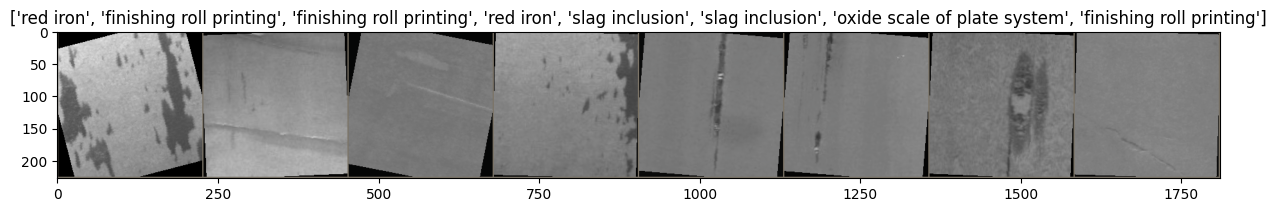

In [14]:
#
# Helper function untuk menampilkan gambar
def imshow(inp, title=None):
    """Menampilkan gambar tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    # De-normalisasi
    mean = np.array(IMAGE_NET_MEAN)
    std = np.array(IMAGE_NET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Ambil satu batch data latih
inputs, classes = next(iter(train_loader))

# Buat grid dari batch
out = torchvision.utils.make_grid(inputs[:8]) 
plt.figure(figsize=(15, 5))
imshow(out, title=[class_names[x] for x in classes[:8]])

In [6]:
def get_model(model_name, num_classes=7):
    model = None
    
    if model_name == 'mobilenet':
        # Sesuai proposal: MobileNet
        model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == 'mobilevit':
        # Buat model MobileViT dari timm
        model = timm.create_model('mobilevit_xs', pretrained=True)
        
        # Cara yang benar untuk mengganti classifier di MobileViT
        # MobileViT menggunakan head.fc sebagai classifier
        if hasattr(model, 'head'):
            if hasattr(model.head, 'fc'):
                # Untuk model dengan head.fc
                num_ftrs = model.head.fc.in_features
                model.head.fc = nn.Linear(num_ftrs, num_classes)
            elif hasattr(model.head, 'in_features'):
                # Untuk model dengan head langsung sebagai Linear
                num_ftrs = model.head.in_features
                model.head = nn.Linear(num_ftrs, num_classes)
            else:
                # Fallback: reset classifier dengan metode timm
                model.reset_classifier(num_classes)
        else:
            # Jika tidak ada head, gunakan metode reset_classifier
            model.reset_classifier(num_classes)
        
    elif model_name == 'swin':
        # Sesuai proposal: Swin Transformer (varian 'tiny')
        model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
        num_ftrs = model.head.in_features
        model.head = nn.Linear(num_ftrs, num_classes) # (in_features, out_features)
        
    else:
        raise ValueError("Nama model tidak dikenal. Pilih 'mobilenet', 'mobilevit', atau 'swin'.")
        
    return model

print("Fungsi 'get_model' v2 (FINAL) berhasil didefinisikan.")

Fungsi 'get_model' v2 (FINAL) berhasil didefinisikan.


In [7]:
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    model.to(device)
    
    best_val_acc = 0.0
    best_model_path = f"best_model_{model_name}.pth"
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Memulai pelatihan {model_name} di {device}...")
    
    # DEBUGGING: Check data format
    print("\n=== Checking Data Format ===")
    for inputs, labels in train_loader:
        print(f"Input shape: {inputs.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Labels dtype: {labels.dtype}")
        print(f"Labels range: [{labels.min()}, {labels.max()}]")
        
        # Test forward pass
        inputs_test = inputs.to(device)
        labels_test = labels.to(device)
        outputs_test = model(inputs_test)
        print(f"Model output shape: {outputs_test.shape}")
        print("=== Data Check Complete ===\n")
        break

    for epoch in range(num_epochs):
        start_time = time.time()
        
        # --- Tahap Pelatihan ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # FIX: Ensure labels are Long type (integer)
            if labels.dtype != torch.long:
                labels = labels.long()
            
            # FIX: Flatten labels if needed (remove extra dimensions)
            if len(labels.shape) > 1:
                labels = labels.squeeze()
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            # FIX: Ensure outputs have correct shape
            if len(outputs.shape) > 2:
                outputs = outputs.view(outputs.size(0), -1)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # --- Tahap Validasi ---
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # FIX: Apply same fixes for validation
                if labels.dtype != torch.long:
                    labels = labels.long()
                
                if len(labels.shape) > 1:
                    labels = labels.squeeze()
                
                outputs = model(inputs)
                
                if len(outputs.shape) > 2:
                    outputs = outputs.view(outputs.size(0), -1)
                
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        # Simpan history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())
        
        # Perbarui learning rate
        scheduler.step()
        
        end_time = time.time()
        
        print(f"Epoch {epoch+1}/{num_epochs} | Waktu: {end_time - start_time:.2f}s | LR: {scheduler.get_last_lr()[0]:.1e}")
        print(f"  Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"  Val   Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

        # Simpan model terbaik
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"  -> Model terbaik disimpan ke {best_model_path} (Akurasi: {best_val_acc:.4f})")
            
    print(f"Pelatihan selesai. Model terbaik disimpan di {best_model_path}")
    return best_model_path, history

In [8]:

all_histories = {}
all_best_paths = {}

# Model Mobile Net

In [11]:
#
# --- EKSPERIMEN 1: MobileNet ---
print("="*30)
print("Memulai Eksperimen 1: MobileNet")
print("="*30)

model_name_1 = 'mobilenet'
model_1 = get_model(model_name_1, NUM_CLASSES)

# Hiperparameter sesuai proposal
criterion_1 = nn.CrossEntropyLoss() # [cite: 414]
optimizer_1 = optim.AdamW(model_1.parameters(), lr=LEARNING_RATE) # [cite: 427]
scheduler_1 = CosineAnnealingLR(optimizer_1, T_max=NUM_EPOCHS) # [cite: 430]

# Mulai pelatihan
best_path, history = train_model(model_1, model_name_1, 
                                 train_loader, val_loader, 
                                 criterion_1, optimizer_1, scheduler_1, 
                                 num_epochs=NUM_EPOCHS)

all_histories[model_name_1] = history
all_best_paths[model_name_1] = best_path

Memulai Eksperimen 1: MobileNet
Memulai pelatihan mobilenet di cpu...
Epoch 1/100 | Waktu: 142.38s | LR: 1.0e-04
  Train Loss: 1.0027 Acc: 0.7061
  Val   Loss: 0.6875 Acc: 0.7664
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.7664)
Epoch 2/100 | Waktu: 146.49s | LR: 1.0e-04
  Train Loss: 0.2575 Acc: 0.9357
  Val   Loss: 0.1180 Acc: 0.9836
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.9836)
Epoch 3/100 | Waktu: 154.85s | LR: 1.0e-04
  Train Loss: 0.1149 Acc: 0.9765
  Val   Loss: 0.0520 Acc: 0.9877
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.9877)
Epoch 4/100 | Waktu: 157.07s | LR: 1.0e-04
  Train Loss: 0.0706 Acc: 0.9867
  Val   Loss: 0.0322 Acc: 0.9918
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.9918)
Epoch 5/100 | Waktu: 159.47s | LR: 9.9e-05
  Train Loss: 0.0458 Acc: 0.9908
  Val   Loss: 0.0279 Acc: 0.9959
  -> Model terbaik disimpan ke best_model_mobilenet.pth (Akurasi: 0.9959)
Epoch 6/100 | W

# Mobile Vit

In [19]:
#
# --- EKSPERIMEN 2: MobileViT ---
print("="*30)
print("Memulai Eksperimen 2: MobileViT")
print("="*30)

model_name_2 = 'mobilevit'
model_2 = get_model(model_name_2, NUM_CLASSES)

# Hiperparameter
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.AdamW(model_2.parameters(), lr=LEARNING_RATE)
scheduler_2 = CosineAnnealingLR(optimizer_2, T_max=NUM_EPOCHS)

# Mulai pelatihan
best_path, history = train_model(model_2, model_name_2, train_loader, val_loader, criterion_2, optimizer_2, scheduler_2, num_epochs=NUM_EPOCHS)

all_histories[model_name_2] = history
all_best_paths[model_name_2] = best_path

Memulai Eksperimen 2: MobileViT
Memulai pelatihan mobilevit di cpu...
Epoch 1/100 | Waktu: 178.25s | LR: 1.0e-04
  Train Loss: 1.7751 Acc: 0.5051
  Val   Loss: 1.6161 Acc: 0.7213
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.7213)
Epoch 2/100 | Waktu: 176.61s | LR: 1.0e-04
  Train Loss: 1.2957 Acc: 0.8439
  Val   Loss: 1.0421 Acc: 0.9344
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.9344)
Epoch 3/100 | Waktu: 188.88s | LR: 1.0e-04
  Train Loss: 0.7715 Acc: 0.9378
  Val   Loss: 0.5575 Acc: 0.9672
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.9672)
Epoch 4/100 | Waktu: 182.51s | LR: 1.0e-04
  Train Loss: 0.4678 Acc: 0.9520
  Val   Loss: 0.2894 Acc: 0.9754
  -> Model terbaik disimpan ke best_model_mobilevit.pth (Akurasi: 0.9754)
Epoch 5/100 | Waktu: 183.41s | LR: 9.9e-05
  Train Loss: 0.3036 Acc: 0.9612
  Val   Loss: 0.2137 Acc: 0.9713
Epoch 6/100 | Waktu: 182.88s | LR: 9.9e-05
  Train Loss: 0.2102 Acc: 0.9786
  Val   Loss:

# Swin T

In [9]:
#
# --- EKSPERIMEN 3: Swin Transformer ---
print("="*30)
print("Memulai Eksperimen 3: Swin Transformer")
print("="*30)

model_name_3 = 'swin'
model_3 = get_model(model_name_3, NUM_CLASSES)

# Hiperparameter
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.AdamW(model_3.parameters(), lr=LEARNING_RATE)
scheduler_3 = CosineAnnealingLR(optimizer_3, T_max=NUM_EPOCHS)

# Mulai pelatihan
best_path, history = train_model(model_3, model_name_3, 
train_loader, val_loader, 
criterion_3, optimizer_3, scheduler_3, 
num_epochs=NUM_EPOCHS)

all_histories[model_name_3] = history
all_best_paths[model_name_3] = best_path

Memulai Eksperimen 3: Swin Transformer
Memulai pelatihan swin di cpu...

=== Checking Data Format ===
Input shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Labels dtype: torch.int64
Labels range: [0, 6]
Model output shape: torch.Size([32, 7, 7, 7])
=== Data Check Complete ===

Epoch 1/100 | Waktu: 339.98s | LR: 1.0e-04
  Train Loss: 2.2299 Acc: 0.4418
  Val   Loss: 3.0582 Acc: 0.4180
  -> Model terbaik disimpan ke best_model_swin.pth (Akurasi: 0.4180)
Epoch 2/100 | Waktu: 341.44s | LR: 1.0e-04
  Train Loss: 0.4031 Acc: 0.8837
  Val   Loss: 0.8162 Acc: 0.9057
  -> Model terbaik disimpan ke best_model_swin.pth (Akurasi: 0.9057)


KeyboardInterrupt: 

# Grafik Comparison 

In [ ]:
#
plt.figure(figsize=(20, 10))

# Plot Akurasi
plt.subplot(1, 2, 1)
for model_name in MODEL_NAMES:
    plt.plot(all_histories[model_name]['val_acc'], label=f'{model_name} Val Acc')
plt.title('Perbandingan Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
for model_name in MODEL_NAMES:
    plt.plot(all_histories[model_name]['val_loss'], label=f'{model_name} Val Loss')
plt.title('Perbandingan Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("perbandingan_grafik_pelatihan.png")
plt.show()

# Evaluate Model

In [ ]:
#
def evaluate_model(model_name, model_path, test_loader, class_names):
    # Muat model
    model = get_model(model_name, NUM_CLASSES)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    print(f"\nMengevaluasi {model_name} pada data test...")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Hitung Metrik [cite: 445]
    report = classification_report(all_labels, all_preds, 
                                   target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"--- Laporan Klasifikasi untuk {model_name} ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot Confusion Matrix [cite: 445]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f"confusion_matrix_{model_name}.png")
    print(f"Confusion matrix disimpan ke confusion_matrix_{model_name}.png")
    
    # Ambil metrik utama
    return {
        'accuracy': report['accuracy'],
        'precision (macro)': report['macro avg']['precision'],
        'recall (macro)': report['macro avg']['recall'],
        'f1-score (macro)': report['macro avg']['f1-score']
    }

In [ ]:
#
all_reports = {}

for model_name in MODEL_NAMES:
    model_path = all_best_paths[model_name]
    report = evaluate_model(model_name, model_path, test_loader, class_names)
    all_reports[model_name] = report

# --- HASIL AKHIR ---
print("\n" + "="*50)
print("     PERBANDINGAN KINERJA MODEL FINAL (DATA TEST)      ")
print("="*50)

# Ubah ke DataFrame Pandas biar rapi
df_report = pd.DataFrame.from_dict(all_reports, orient='index')
print(df_report.to_markdown(floatfmt=".4f"))

# Simpan ke file
df_report.to_csv("perbandingan_model_final.csv")
print("\nPerbandingan final disimpan ke perbandingan_model_final.csv")

# Evaluate Model coba

In [ ]:
#
def evaluate_model(model_name, model_path, test_loader, class_names):
    """
    Fungsi untuk memuat model dan mengevaluasinya pada data uji.
    """
    # 1. Muat arsitektur model
    model = get_model(model_name, NUM_CLASSES)
    
    # 2. Muat bobot (weights) terbaik yang sudah kamu latih
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval() # Set model ke mode evaluasi (penting!)
    
    all_preds = []
    all_labels = []
    
    print(f"\nMengevaluasi {model_name} pada {len(test_loader.dataset)} data uji...")
    
    # Matikan perhitungan gradien untuk hemat memori
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Lakukan prediksi
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Kumpulkan semua prediksi dan label asli
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # 3. Hitung Metrik
    accuracy = accuracy_score(all_labels, all_preds)
    report_dict = classification_report(all_labels, all_preds, 
                                        target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)
    
    print("="*50)
    print(f"--- HASIL EVALUASI: {model_name} ---")
    print(f"Akurasi Keseluruhan: {accuracy * 100:.2f}%")
    print("="*50)

    print("Laporan Klasifikasi Lengkap:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 5. Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f"confusion_matrix_{model_name}.png")
    print(f"\nConfusion matrix disimpan ke confusion_matrix_{model_name}.png")
    
    return report_dict

print("Fungsi 'evaluate_model' siap digunakan.")

Fungsi 'evaluate_model' siap digunakan.


In [10]:
# --- 1. GANTI DENGAN MODEL ANDA ---
# Ganti bagian placeholder dari jawaban sebelumnya dengan kode ini.

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2 

JUMLAH_KELAS_ANDA = 7 

# 1. Inisialisasi arsitektur model (MobileNetV2)
# Kita set 'weights=None' karena kita akan memuat bobot dari file Anda,
# bukan bobot default ImageNet.
model = mobilenet_v2(weights=None)

# 2. Sesuaikan layer classifier terakhir
# Kita perlu mengganti layer 'classifier' terakhir dari MobileNetV2
# agar sesuai dengan jumlah kelas keluaran Anda.
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, JUMLAH_KELAS_ANDA)

# 3. Tentukan path ke file model Anda
# Gunakan 'r' di depan string agar Python membaca path Windows ('\') dengan benar
PATH_MODEL_ANDA = r"C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_mobilenet.pth"

# 4. Muat bobot (state_dict) yang telah Anda latih
# 'map_location=device' memastikan model dimuat ke device yang benar (CPU atau GPU)
try:
    model.load_state_dict(torch.load(PATH_MODEL_ANDA, map_location=device))
    print(f"Model state_dict berhasil dimuat dari: {PATH_MODEL_ANDA}")
except RuntimeError as e:
    print(f"Gagal memuat state_dict, mencoba memuat seluruh model... Error: {e}")
    # Jika baris di atas error, mungkin Anda menyimpan seluruh model,
    # bukan hanya state_dict. Kita coba muat seluruh model.
    try:
        model = torch.load(PATH_MODEL_ANDA, map_location=device)
        print(f"Seluruh model berhasil dimuat dari: {PATH_MODEL_ANDA}")
    except Exception as e_full:
        print(f"GAGAL TOTAL memuat model. Pastikan arsitektur (jumlah kelas) sudah benar.")
        print(f"Error: {e_full}")
        
# 5. Pindahkan model ke device (GPU/CPU) dan set ke mode evaluasi
model.to(device)
model.eval()
# ---------------------------------

Model state_dict berhasil dimuat dari: C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_mobilenet.pth


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Sel 2: Kode Evaluasi Utama

import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import mobilenet_v2
from torchvision import datasets, transforms # <-- Penting untuk memuat data asli

# Tentukan device (Gunakan GPU jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# --- 1. MEMUAT MODEL ANDA (Sudah Disesuaikan) ---
# Kode ini sudah disesuaikan untuk memuat file best_model_mobilenet.pth Anda.

# ⚠️ PENTING: GANTI ANGKA INI!
# Sesuaikan dengan jumlah kelas keluaran model Anda (misal: 3, 5, 10, dll.)
JUMLAH_KELAS_ANDA = 7 

# 1. Inisialisasi arsitektur model (MobileNetV2)
model = mobilenet_v2(weights=None) # weights=None karena kita akan muat dari file

# 2. Sesuaikan layer classifier terakhir
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, JUMLAH_KELAS_ANDA)

# 3. Tentukan path ke file model Anda
# Gunakan 'r' di depan string agar Python membaca path Windows ('\') dengan benar
PATH_MODEL_ANDA = r"C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_mobilenet.pth"

# 4. Muat bobot (state_dict) yang telah Anda latih
try:
    model.load_state_dict(torch.load(PATH_MODEL_ANDA, map_location=device))
    print(f"Model state_dict berhasil dimuat dari: {PATH_MODEL_ANDA}")
except RuntimeError as e:
    print(f"Gagal memuat state_dict, mencoba memuat seluruh model... Error: {e}")
    # Jika baris di atas error, mungkin Anda menyimpan seluruh model,
    # bukan hanya state_dict. Kita coba muat seluruh model.
    try:
        model = torch.load(PATH_MODEL_ANDA, map_location=device)
        print(f"Seluruh model berhasil dimuat dari: {PATH_MODEL_ANDA}")
    except Exception as e_full:
        print(f"GAGAL TOTAL memuat model. Pastikan arsitektur dan JUMLAH_KELAS_ANDA sudah benar.")
        print(f"Error: {e_full}")
        
# 5. Pindahkan model ke device (GPU/CPU) dan set ke mode evaluasi
model.to(device)
model.eval() # PENTING: Set model ke mode evaluasi
# ---------------------------------


# --- 2. ⚠️ GANTI DENGAN DATA TES ANDA ---
# Anda WAJIB mengganti bagian placeholder di bawah ini dengan data tes Anda yang sesungguhnya.
# Gunakan kode yang mirip seperti ini:
# ---------------------------------
# # CONTOH KODE DATA ASLI (HAPUS TANDA ' #' UNTUK MENGGUNAKAN)

# # Tentukan transform (samakan persis dengan saat training)
# data_transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# # Path ke folder data tes Anda (misal: .../dataset/test)
# PATH_DATA_TES_ANDA = r"C:\path\ke\folder\data_tes_anda" 

# test_dataset = datasets.ImageFolder(PATH_DATA_TES_ANDA, transform=data_transform)

# BATCH_SIZE = 32 # Sesuaikan jika perlu
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print(f"Data tes asli berhasil dimuat dari: {PATH_DATA_TES_ANDA}")
# x_test_tensor = torch.randn(1, 3, 224, 224) # dummy untuk speed test
# ---------------------------------


# ---------------------------------
# DATA TES PLACEHOLDER (HAPUS ATAU GANTI BAGIAN INI)
# Kode di bawah ini hanya untuk pengujian, gunakan kode di atas untuk data asli Anda.
print("Membuat data tes placeholder... (INGAT GANTI DENGAN DATA ASLI ANDA!)")
JUMLAH_SAMPEL_TES = 100
UKURAN_GAMBAR = (3, 224, 224) # PyTorch: (Channels, Height, Width)
JUMLAH_KELAS = JUMLAH_KELAS_ANDA # Gunakan jumlah kelas yang sama
BATCH_SIZE = 32

# Buat tensor acak (pastikan di-normalisasi seperti data training Anda)
x_test_tensor = torch.randn(JUMLAH_SAMPEL_TES, *UKURAN_GAMBAR, dtype=torch.float32)
# Buat label acak
y_test_tensor = torch.randint(0, JUMLAH_KELAS, (JUMLAH_SAMPEL_TES,))

# Buat DataLoader placeholder
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"DataLoader placeholder dibuat.")
# ----------------------------------


## 📊 Evaluasi Metrik (Akurasi, Presisi, Recall, F1)
print("\n--- Mengevaluasi Metrik Klasifikasi ---")

all_preds = []
all_labels = []

# Matikan perhitungan gradien untuk evaluasi
with torch.no_grad():
    for images, labels in test_loader:
        # Pindahkan data ke device (GPU/CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Dapatkan output model
        outputs = model(images)
        
        # Dapatkan kelas prediksi (indeks dengan nilai tertinggi)
        _, predicted = torch.max(outputs.data, 1)
        
        # Kumpulkan semua prediksi dan label
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hitung dan tampilkan metrik
accuracy = accuracy_score(all_labels, all_preds)
print(f"Akurasi Keseluruhan: {accuracy:.4f}\n")
print("Laporan Klasifikasi Lengkap:")
# zero_division=0 untuk menghindari error jika ada kelas tanpa sampel
print(classification_report(all_labels, all_preds, zero_division=0))

# Tampilkan Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()


## ⏱️ Evaluasi Kecepatan Inferensi
print("\n--- Mengevaluasi Kecepatan Inferensi ---")

# Buat satu sampel data untuk diuji (batch size = 1)
# (Menggunakan data pertama dari placeholder)
sample_image = x_test_tensor[0:1].to(device) 
print(f"Menguji kecepatan dengan 1 gambar (shape: {sample_image.shape})")

# Pemanasan (Warm-up)
for _ in range(10):
    _ = model(sample_image)

# Sinkronisasi CUDA (jika pakai GPU) untuk pengukuran yang akurat
if device.type == 'cuda':
    torch.cuda.synchronize()

# Mulai pengukuran
start_time = time.time()
JUMLAH_ITERASI_WAKTU = 100
with torch.no_grad():
    for _ in range(JUMLAH_ITERASI_WAKTU):
        _ = model(sample_image)
        # Sinkronisasi lagi di dalam loop untuk akurasi per inferensi
        if device.type == 'cuda':
            torch.cuda.synchronize()

end_time = time.time()

# Hitung hasil
total_time = end_time - start_time
avg_time_per_inference = total_time / JUMLAH_ITERASI_WAKTU
fps = 1 / avg_time_per_inference

print(f"Jumlah inferensi: {JUMLAH_ITERASI_WAKTU}")
print(f"Total waktu: {total_time:.4f} detik")
print(f"Waktu rata-rata per inferensi: {avg_time_per_inference * 1000:.4f} ms")
print(f"Frames Per Second (FPS): {fps:.2f}")

Menggunakan path model manual:
{'mobilenet': 'C:\\Document\\TAAAAA CUYYYY\\X-SDD\\TA_Klasifikasi_Cacat\\best_model_mobilenet.pth', 'mobilevit': 'C:\\Document\\TAAAAA CUYYYY\\X-SDD\\TA_Klasifikasi_Cacat\\best_model_mobilevit.pth', 'swin': 'C:\\Document\\TAAAAA CUYYYY\\X-SDD\\TA_Klasifikasi_Cacat\\best_model_swin.pth'}

===== Mengevaluasi Model: mobilenet =====
Memuat model dari: C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_mobilenet.pth
State dict berhasil dimuat.
Memulai evaluasi pada 136 data uji...

--- Laporan Klasifikasi ---
                                   precision    recall  f1-score   support

          finishing roll printing       1.00      1.00      1.00        20
                   iron sheet ash       0.92      0.92      0.92        12
      oxide scale of plate system       1.00      1.00      1.00         6
oxide scale of temperature system       1.00      1.00      1.00        20
                         red iron       0.98      1.00      0.99      

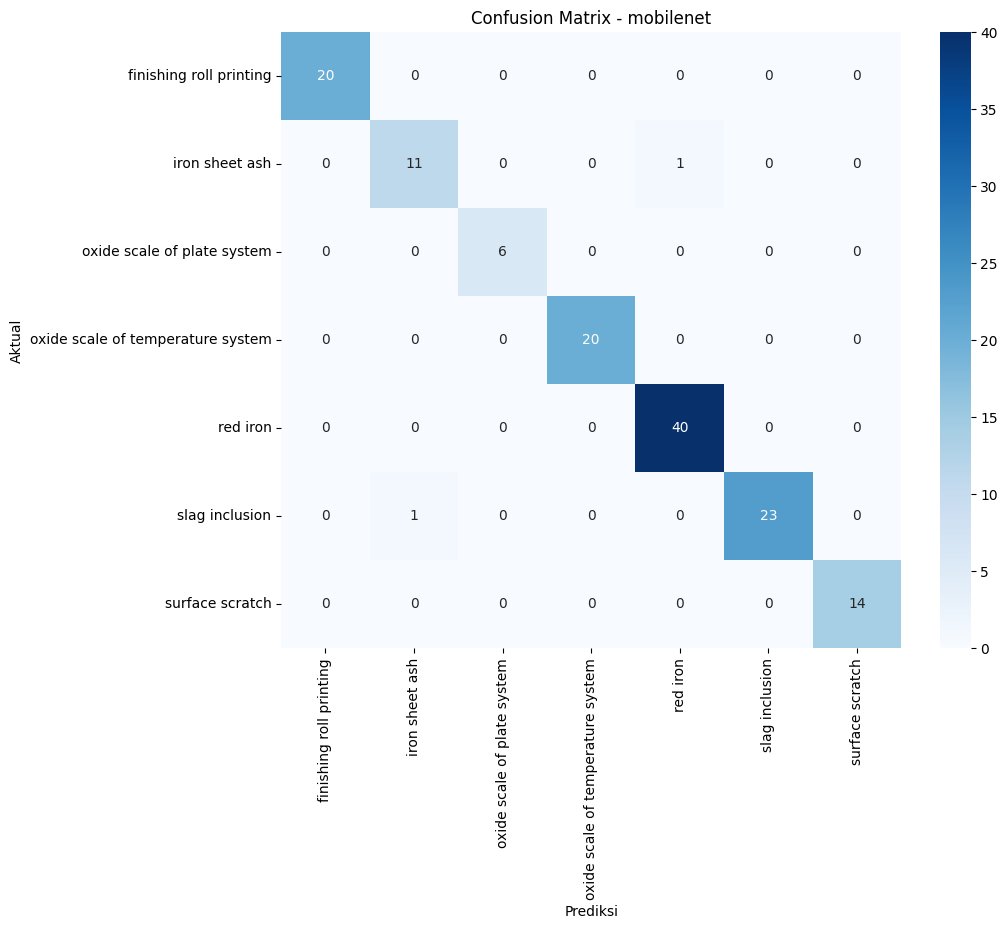


===== Mengevaluasi Model: mobilevit =====
Memuat model dari: C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_mobilevit.pth
State dict berhasil dimuat.
Memulai evaluasi pada 136 data uji...

--- Laporan Klasifikasi ---
                                   precision    recall  f1-score   support

          finishing roll printing       1.00      1.00      1.00        20
                   iron sheet ash       0.92      1.00      0.96        12
      oxide scale of plate system       1.00      1.00      1.00         6
oxide scale of temperature system       1.00      1.00      1.00        20
                         red iron       1.00      1.00      1.00        40
                   slag inclusion       1.00      0.96      0.98        24
                  surface scratch       1.00      1.00      1.00        14

                         accuracy                           0.99       136
                        macro avg       0.99      0.99      0.99       136
             

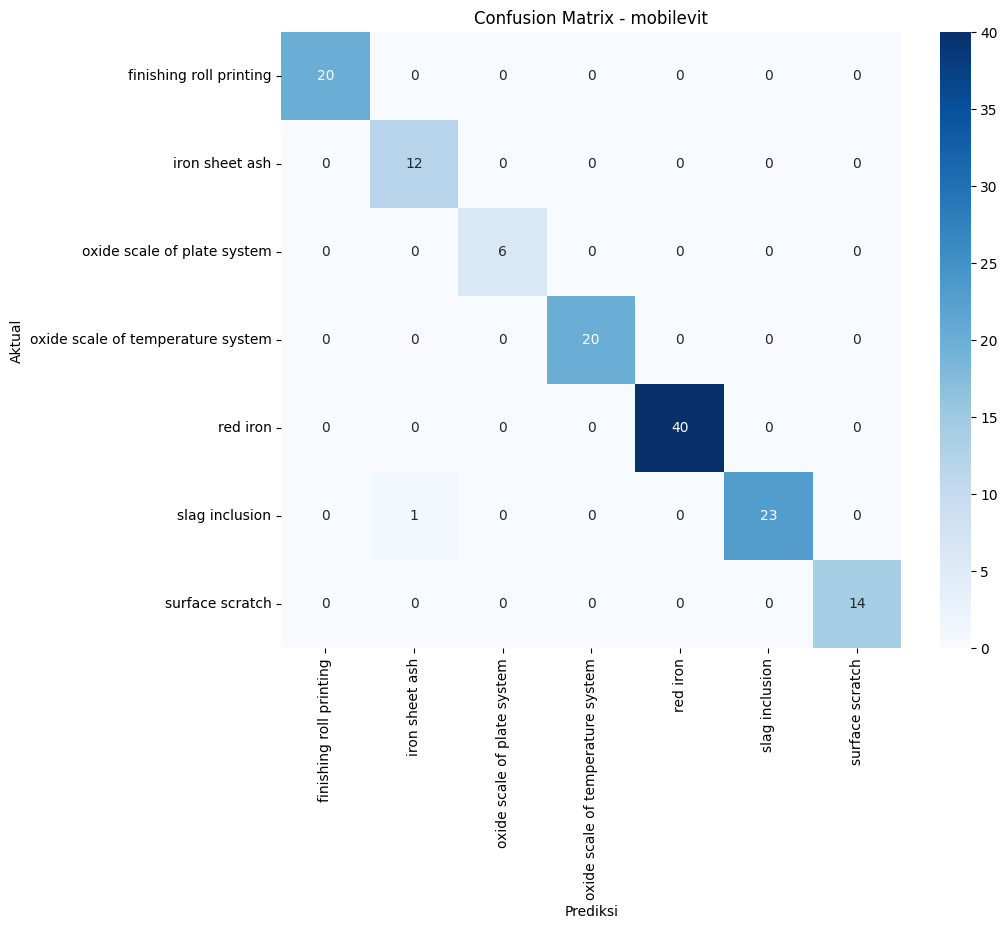


===== Mengevaluasi Model: swin =====
Memuat model dari: C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_swin.pth
State dict berhasil dimuat.
Memulai evaluasi pada 136 data uji...

--- Laporan Klasifikasi ---
                                   precision    recall  f1-score   support

          finishing roll printing       0.18      0.85      0.30        20
                   iron sheet ash       0.00      0.00      0.00        12
      oxide scale of plate system       0.00      0.00      0.00         6
oxide scale of temperature system       0.00      0.00      0.00        20
                         red iron       0.00      0.00      0.00        40
                   slag inclusion       0.00      0.00      0.00        24
                  surface scratch       0.06      0.14      0.08        14

                         accuracy                           0.14       136
                        macro avg       0.03      0.14      0.05       136
                     we

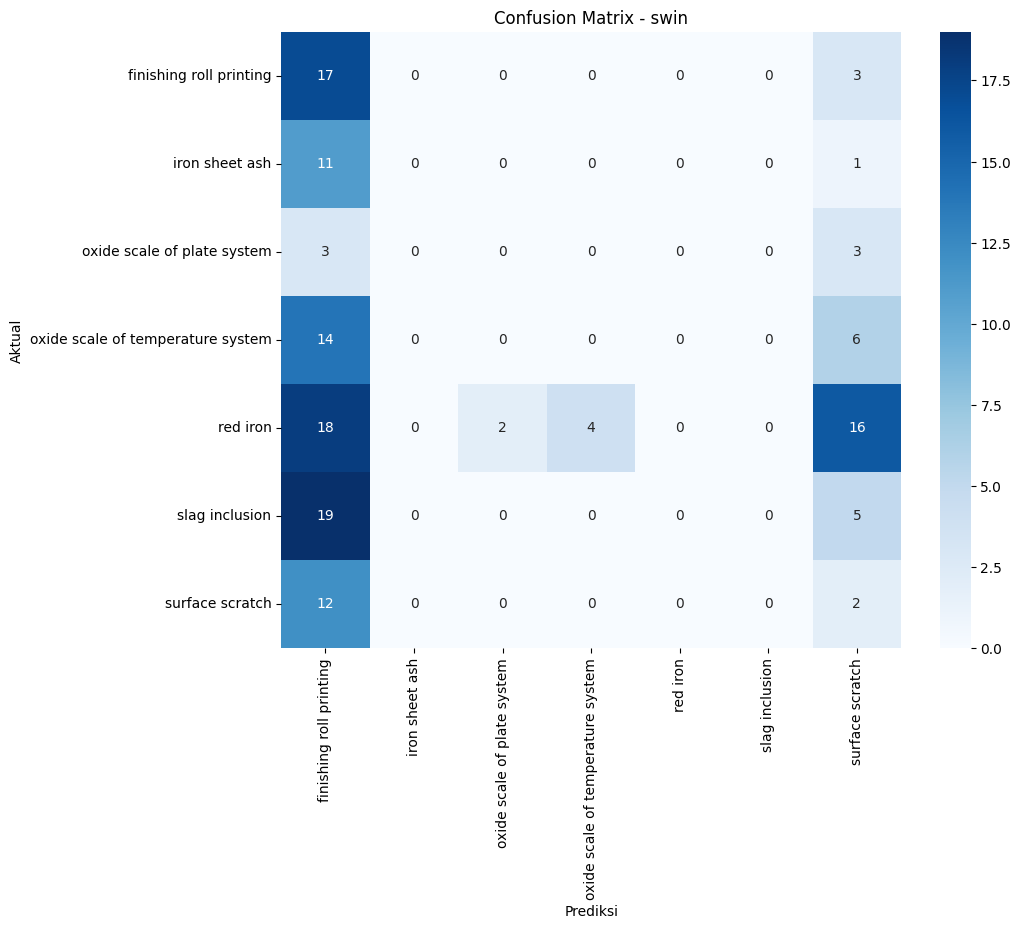


     PERBANDINGAN KINERJA MODEL FINAL (DATA TEST)      
|           |   accuracy |   precision (macro) |   recall (macro) |   f1-score (macro) |
|:----------|-----------:|--------------------:|-----------------:|-------------------:|
| mobilenet |     0.9853 |              0.9846 |           0.9821 |             0.9833 |
| mobilevit |     0.9926 |              0.9890 |           0.9940 |             0.9912 |
| swin      |     0.1397 |              0.0338 |           0.1418 |             0.0540 |

Perbandingan final disimpan ke perbandingan_model_final.csv


In [17]:
# Cell: Evaluasi Model pada Data Uji (Versi Path Manual)

import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Pastikan numpy diimpor jika belum

# --- FUNGSI EVALUASI (Sama seperti sebelumnya) ---
def evaluate_model_on_test(model_name, model_path, test_loader, class_names, num_classes):
    """
    Memuat model dari path, mengevaluasi pada test_loader,
    mencetak laporan, dan menampilkan confusion matrix.
    """
    print(f"\n===== Mengevaluasi Model: {model_name} =====")
    print(f"Memuat model dari: {model_path}")

    # 1. Muat arsitektur model
    model = get_model(model_name, num_classes) # Gunakan fungsi get_model Anda

    # 2. Muat bobot (weights) terbaik
    try:
        # Pindahkan model ke device SEBELUM memuat state_dict jika map_location tidak digunakan
        model.to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("State dict berhasil dimuat.")
    except Exception as e:
        print(f"Gagal memuat state_dict, error: {e}")
        print("Pastikan path model benar dan arsitektur get_model cocok.")
        return None # Hentikan jika model tidak bisa dimuat

    model.eval() # Set model ke mode evaluasi

    all_preds = []
    all_labels = []

    print(f"Memulai evaluasi pada {len(test_loader.dataset)} data uji...")

    # Matikan perhitungan gradien
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Perbaikan: Handle output Swin Transformer yang mungkin berbeda
            if isinstance(outputs, tuple): # Jika output adalah tuple (misal: Swin)
                outputs = outputs[0]
            if len(outputs.shape) > 2 and outputs.shape[2] > 1: # Cek jika output perlu pooling/flatten tambahan
                 # Tambahkan Global Average Pooling jika output masih spasial (misal: [batch, features, H, W])
                 pool = nn.AdaptiveAvgPool2d((1, 1))
                 outputs = pool(outputs)
                 outputs = torch.flatten(outputs, 1)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 3. Hitung dan Tampilkan Metrik
    print("\n--- Laporan Klasifikasi ---")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    report_dict = classification_report(all_labels, all_preds,
                                        target_names=class_names, output_dict=True, zero_division=0)
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Akurasi Keseluruhan: {accuracy:.4f}")

    # 4. Tampilkan Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix - {model_name}')
    img_filename = f"confusion_matrix_{model_name}.png"
    plt.savefig(img_filename)
    print(f"Confusion matrix disimpan ke {img_filename}")
    plt.show() # Tampilkan plot di notebook

    # 5. Kembalikan metrik utama untuk perbandingan
    return {
        'accuracy': report_dict['accuracy'],
        'precision (macro)': report_dict['macro avg']['precision'],
        'recall (macro)': report_dict['macro avg']['recall'],
        'f1-score (macro)': report_dict['macro avg']['f1-score']
    }

# --- MENJALANKAN EVALUASI UNTUK SEMUA MODEL ---

# !! GANTI BAGIAN INI DENGAN PATH MANUAL !!
# Pastikan path ini benar sesuai lokasi file .pth Anda
all_best_paths = {
    'mobilenet': r"C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_mobilenet.pth",
    'mobilevit': r"C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_mobilevit.pth",
    'swin': r"C:\Document\TAAAAA CUYYYY\X-SDD\TA_Klasifikasi_Cacat\best_model_swin.pth"
}
print("Menggunakan path model manual:")
print(all_best_paths)

MODEL_NAMES_TO_EVAL = list(all_best_paths.keys()) # Ambil nama model dari dictionary manual

# Variabel lain yang dibutuhkan (pastikan sudah ada dari cell sebelumnya)
# test_loader = ...
# class_names = ...
# NUM_CLASSES = 7

all_reports = {}

# Loop evaluasi (kode selanjutnya sama seperti sebelumnya)
for model_name in MODEL_NAMES_TO_EVAL:
    if model_name in all_best_paths:
        model_path = all_best_paths[model_name]
        # Panggil fungsi evaluasi
        report = evaluate_model_on_test(model_name, model_path, test_loader, class_names, NUM_CLASSES)
        if report: # Hanya tambahkan jika evaluasi berhasil
             all_reports[model_name] = report
    else:
        # Seharusnya tidak terjadi karena kita definisikan manual di atas
        print(f"WARNING: Path model terbaik untuk {model_name} tidak ditemukan. Lewati evaluasi.")


# --- MENAMPILKAN TABEL PERBANDINGAN AKHIR ---
if all_reports: # Hanya tampilkan jika ada hasil
    print("\n" + "="*50)
    print("     PERBANDINGAN KINERJA MODEL FINAL (DATA TEST)      ")
    print("="*50)

    # Ubah ke DataFrame Pandas
    df_report = pd.DataFrame.from_dict(all_reports, orient='index')

    # Tampilkan DataFrame dalam format Markdown (bagus untuk notebook)
    print(df_report.to_markdown(floatfmt=".4f"))

    # Simpan ke file CSV
    csv_filename = "perbandingan_model_final.csv"
    try:
        df_report.to_csv(csv_filename)
        print(f"\nPerbandingan final disimpan ke {csv_filename}")
        # Memberi tahu pengguna nama file CSV yang dihasilkan
        # @fileTag(csv_filename)
    except Exception as e:
        print(f"\nGagal menyimpan perbandingan ke CSV: {e}")
else:
    print("\nTidak ada hasil evaluasi untuk ditampilkan.")